In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [18]:
! pwd
! pip install -e ..  -r requirements.txt

/kaggle/working/kaggle/titanic


Obtaining file:///kaggle/working/kaggle
  Preparing metadata (setup.py) ... done
  Attempting uninstall: kaggle_common
    Found existing installation: kaggle_common 0.1.0
    Uninstalling kaggle_common-0.1.0:
      Successfully uninstalled kaggle_common-0.1.0
  Running setup.py develop for kaggle_common


# Imports & config

In [20]:
# (second cell) Python imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics       import classification_report, accuracy_score

# reusable bits
from common.preprocessing import make_preprocessor
from common.pipelines     import compare_models, grid_search

# models
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm            import SVC
# 2) Imports
from common.preprocessing import make_preprocessor
from common.pipelines     import compare_models, grid_search
from sklearn.pipeline import Pipeline

In [9]:
# load straight from Kaggle’s mount
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test  = pd.read_csv('/kaggle/input/titanic/test.csv')

print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory data analysis

In [ ]:
train.isnull().mean().sort_values(ascending=False) * 100 # missingness

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [ ]:
display(pd.crosstab(train['Pclass'], train['Survived'], normalize='index')) # survival rate by category
display(pd.crosstab(train['Sex'],   train['Survived'], normalize='index'))


Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


<Axes: title={'center': 'Fare'}, xlabel='Pclass'>

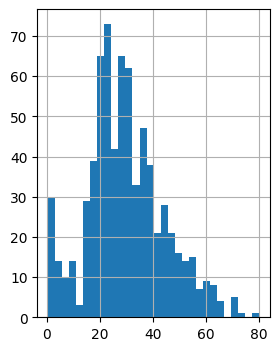

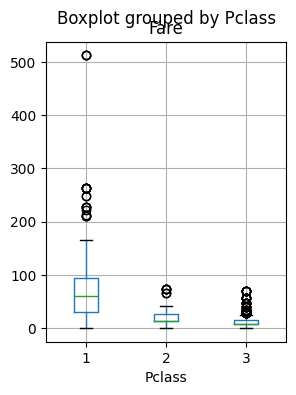

In [ ]:
train['Age'].hist(bins=30, figsize=(3,4)) 
train.boxplot('Fare', by='Pclass', figsize=(3,4))


# Define Features & Split

In [15]:
NUM_COLS = ['Age','Fare']
CAT_COLS = ['Sex','Embarked']
TARGET   = 'Survived'

# hold out a validation set
X = train[NUM_COLS + CAT_COLS]
y = train[TARGET]
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Baseline Model Comparison

In [16]:
preproc = make_preprocessor(NUM_COLS, CAT_COLS)

model_defs = {
    'LogisticRegression': {
        'preproc': preproc,
        'clf': LogisticRegression(max_iter=1000)
    },
    'RandomForest': {
        'preproc': preproc,
        'clf': RandomForestClassifier(n_jobs=-1)
    },
    'GradientBoosting': {
        'preproc': preproc,
        'clf': GradientBoostingClassifier()
    },
    'SVM': {
        'preproc': preproc,
        'clf': SVC()
    },
}

baseline_scores = compare_models(model_defs, X_train, y_train)
baseline_scores


SVM                   0.796405
GradientBoosting      0.789402
LogisticRegression    0.783768
RandomForest          0.779612
dtype: float64

In [19]:
from common.pipelines     import compare_models
from common.preprocessing import make_preprocessor


# Hyperparameter tuning

In [21]:
# example: tune RandomForest
rf_pipe = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier())])
rf_grid = {
    'clf__n_estimators': [100,200,300],
    'clf__max_depth':    [None,5,10],
}
rf_search = grid_search(rf_pipe, rf_grid, X_train, y_train)
print(rf_search.best_params_, rf_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'clf__max_depth': 5, 'clf__n_estimators': 200} 0.7978233034571064


# Validate & Report

In [22]:
best_model = rf_search.best_estimator_
val_preds = best_model.predict(X_val)
print("Val Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


Val Accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



# Final Fit & Submission

In [23]:
# retrain on full training data
best_model.fit(train[NUM_COLS + CAT_COLS], train[TARGET])

# predict test set
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived':    best_model.predict(test[NUM_COLS + CAT_COLS])
})
submission.to_csv('submission.csv', index=False)
